<a href="https://colab.research.google.com/github/Nazarshia2889/Intro-To-GANs/blob/main/Introduction_to_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction to Generative Adversarial Networks (GANs)**
With Pytorch and Tensorflow

Arshia Nayebnazar


---



---





In [ ]:
#@title
from IPython.display import Image

Image(url=r'https://i.ibb.co/zS5vJq5/style-resolution.gif')

Table of Contents:

1. What are GANs?
  *  Generative models
  *   GANs
  * Application of GANs
2. GAN Theory
3. Implementing GAN with Pytorch
4. BONUS: Modern GANs
  * Implementing StyleGAN2 with Tensorflow
5. Future and Applications
  * Resources



---





---



## 1. What are GANs?

**Generative Models**:
*   This is an unsupervised learning task in machine learning in which a model learns patterns in the input data's distribution such that it's able to sample from this learned distribution and generate new data, such as images of faces that don't necessarily exist.

**Generative Adversarial Networks**:
* This is a relatively new type of Generative ML Model that is able to generate data through a unique form of training using "Adversarial Networks".
  * GANs treat the generative problem as a supervised learning task by having one model, known as the "Generator", generate fake images, while the "Discriminator" takes in an input batch of fake and real images (of faces for example) and aims to classify whether the image is real or fake. While the Discriminator aims to have the fake data be classified as fake, the Generator aims to have the fake data be classifed as real, creating "adversarial," or competing, networks. A more in-depth look into the model can be found below.

**Applications of GANs**:
* GANs have made great strides in recent years, generating realistic images of faces, animations, editing existing photos, face aging applications, and more.
* It has also been used in support of other models, such as through data augmentation by generating synthetic data samples in cases where the quantity of the training data is insufficient.



---



---





## 2. GAN Theory

In [ ]:
#@title *GAN Training Process*
from IPython.display import Image

Image(url=r'https://miro.medium.com/max/1400/1*6svU8runkDRjyiIvZ6VKMw.gif')

There are two models involved in the training process: the **Generator**, which generates the fake data, and the **Discriminator**, which aims to differentiate the fake from the real data.

The following shows the pseudocode for the GAN training process from the original paper titled "Generative Adversarial Networks" (Goodfellow et al.):

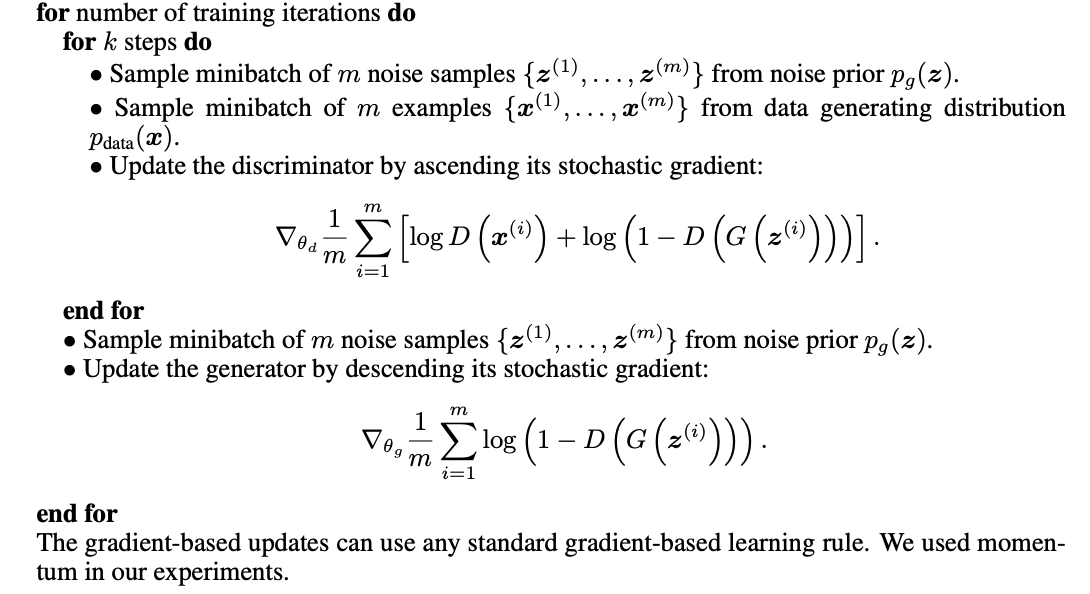



What does this mean? Here's a quick rundown of how the algorithm works:
- The Generator takes in a random vector as its input from a Gaussian distribution called the *z vector*.
 - This vector is also part of a **latent space**: A latent space refers to a compression of a data distribution.

  - Latent spaces are useful because they compress high-dimensional data for input to the GAN. Generating images with a network based on another form of input may be too costly. This is also useful because it allows users to input new random z vectors from a different point in the latent space to generate new images.

  - You can think of the input z vector as the "seed" to the Generator model. The same seed will map to the same generated image after being trained, and a different seed will map to a different generated image after being trained.

- The Generator outputs a batch of images from the input z vector: Initially, this output will not have any clearly defined depiction because the Generator hasn't been trained yet.

- The Discriminator takes in the generated fake data as input. Based on the loss function, the generator wants its generated images to seem as real as possible to "fool" the Discriminator. Therefore, if the Discriminator has a high confidence that the generated images are real, the Generator is doing its job.

*Cost function for Generator*

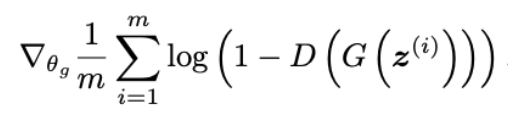

- However, the Discriminator will also be taking real images and fake images as input and will be training on its OWN loss function at the same time. The Discriminator's loss function will reward it for accurately identifying between real images and fake images.

*Cost function for Discriminator*

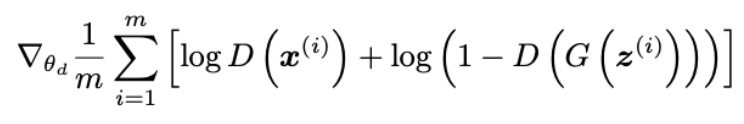

- The Generator's weights are updated based on its own loss function and the Discriminator's weights are updated based on its own loss function.

- In a nutshell, the Generator wants to increase the probability the Discriminator classifies the generated image as real, while the Discriminator aims to reduce it. This results in an "adversarial" training process as both networks compete, driving the Generator to eventually generate realistic images based on the training data.



---



---



## 3. Implementing GAN with Pytorch

Let's create our own Generative Adversarial Network to be able to generate images of digits based on the MNIST dataset.

This is a good dataset to begin with due to the low complexity of each image. GANs take a long time to train, and images with more complex features to generate with a neural network, like faces, are very difficult to train with our resources.

In [ ]:
# Import the necessary libraries
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

In [ ]:
# Let's also import the MNIST dataset
mnist = MNIST(root='data',
              train=True,
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

100%|██████████| 9912422/9912422 [00:00<00:00, 149473342.41it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 101453679.92it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 84933638.68it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 15350949.85it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
# Take a sample image
img, label = mnist[10]

Number: 3


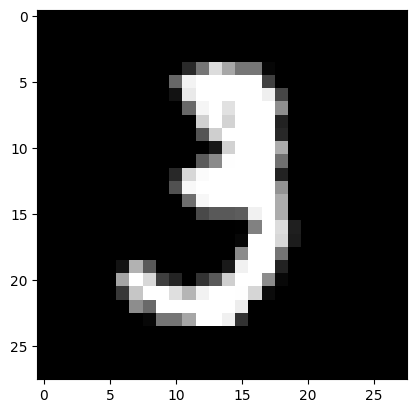

In [ ]:
# Let's take a look at our image!

import matplotlib.pyplot as plt

plt.imshow(img[0], cmap='gray')
print('Number:', label)

In [ ]:
from torch.utils.data import DataLoader

# This will load in the data into the specified batch size
batch_size = 100
data_loader = DataLoader(mnist, batch_size = batch_size, shuffle=True)

In [ ]:
'''
GPUs may allow the training process to go faster, and for a model like GAN, this is essential.
If you would like to use Google Colab's, go to Runtime >> Change runtime type >> Select GPU

The code below will move the model to a GPU if one exists
'''

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
'''
Let's create our Discriminator Network. To do this, we will use the
torch.nn.Module class
'''

class Discriminator(torch.nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    # Define the model
    self.model = torch.nn.Sequential(
        # Hidden Layer - Input is 784 nodes and goes to layer with 256 nodes
        # (input is 784 because each image is 28x28)
        torch.nn.Linear(784, 256),
        # Activation Function: Leaky ReLU
        torch.nn.LeakyReLU(0.2),
        # Second hidden layer, previous number of nodes to next number of nodes (256)
        torch.nn.Linear(256, 256),
        # Activation Function: Leaky ReLU
        torch.nn.LeakyReLU(0.2),
        # Last layer, goes from 256 nodes of previous layer to 1 node output
        # Again, this is one node because it represents the probability
        # of the input images being real or fake
        torch.nn.Linear(256, 1),
        # Sigmoid activation function (probability score)
        torch.nn.Sigmoid())

  # Forward propagation
  def forward(self, img):
    output = self.model(img)
    return output


discriminator = Discriminator()
discriminator = discriminator.to(device)

In [ ]:
'''
Let's create our Generator Network. To do this, we will use the
torch.nn.Module class
'''

latent_size = 64

class Generator(torch.nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    # Define the model
    self.model = torch.nn.Sequential(
      torch.nn.Linear(latent_size, 256),
      torch.nn.ReLU(),
      torch.nn.Linear(256, 256),
      torch.nn.ReLU(),
      torch.nn.Linear(256, 784),
      torch.nn.Tanh())

  # Forward propagation
  def forward(self, img):
    output = self.model(img)
    return output

generator = Generator()

In [ ]:
# As mentioned above, the generator will initially output a nonsensical image since it's not trained

# Random z vector (random starting point/seed for generated image)
z = torch.randn(2, latent_size)
y = generator(z)
gen_imgs = y.reshape((-1, 28,28)).detach()

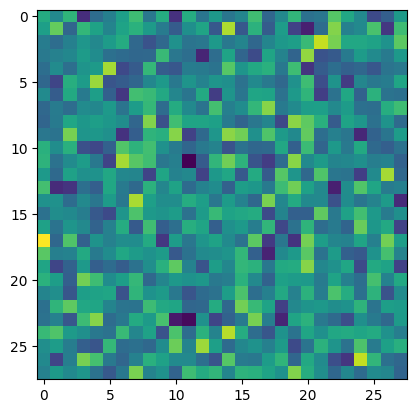

In [ ]:
# The output looks about right!
plt.imshow(gen_imgs[0])

In [ ]:
# Move to correct device
generator.to(device);

In [ ]:
# Reset gradients after every pass
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [ ]:
bce = torch.nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=2e-4)

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = discriminator(images)
    d_loss_real = bce(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = generator(z)
    outputs = discriminator(fake_images)
    d_loss_fake = bce(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

In [ ]:
g_optimizer = torch.optim.Adam(generator.parameters(), lr=2e-4)

def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = generator(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = bce(discriminator(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images


In [ ]:
# Adjust number of epochs
num_epochs = 25
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch {}/{}, d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

Epoch 0/25, d_loss: 0.0537, g_loss: 4.4743, D(x): 0.99, D(G(z)): 0.04
Epoch 0/25, d_loss: 0.1474, g_loss: 5.9234, D(x): 0.93, D(G(z)): 0.05
Epoch 0/25, d_loss: 0.0737, g_loss: 4.9206, D(x): 0.97, D(G(z)): 0.04
Epoch 1/25, d_loss: 0.2338, g_loss: 4.0835, D(x): 0.92, D(G(z)): 0.12
Epoch 1/25, d_loss: 0.0902, g_loss: 4.8163, D(x): 0.95, D(G(z)): 0.02
Epoch 1/25, d_loss: 0.1070, g_loss: 5.0293, D(x): 0.96, D(G(z)): 0.04
Epoch 2/25, d_loss: 0.8597, g_loss: 3.7340, D(x): 0.75, D(G(z)): 0.18
Epoch 2/25, d_loss: 0.1809, g_loss: 4.5965, D(x): 0.97, D(G(z)): 0.11
Epoch 2/25, d_loss: 1.0067, g_loss: 3.4841, D(x): 0.75, D(G(z)): 0.30
Epoch 3/25, d_loss: 0.9121, g_loss: 3.0113, D(x): 0.71, D(G(z)): 0.22
Epoch 3/25, d_loss: 0.6177, g_loss: 2.3564, D(x): 0.86, D(G(z)): 0.27
Epoch 3/25, d_loss: 1.0069, g_loss: 2.3506, D(x): 0.82, D(G(z)): 0.39
Epoch 4/25, d_loss: 0.2871, g_loss: 3.4666, D(x): 0.91, D(G(z)): 0.11
Epoch 4/25, d_loss: 0.4114, g_loss: 3.3383, D(x): 0.82, D(G(z)): 0.07
Epoch 4/25, d_loss: 

In [ ]:
# Generate image
def generate_mnist_image():
  y = generator(torch.randn(2, latent_size).cuda())
  gen_imgs = y.reshape((-1, 28,28)).detach()
  return gen_imgs[0].cpu().data.numpy()

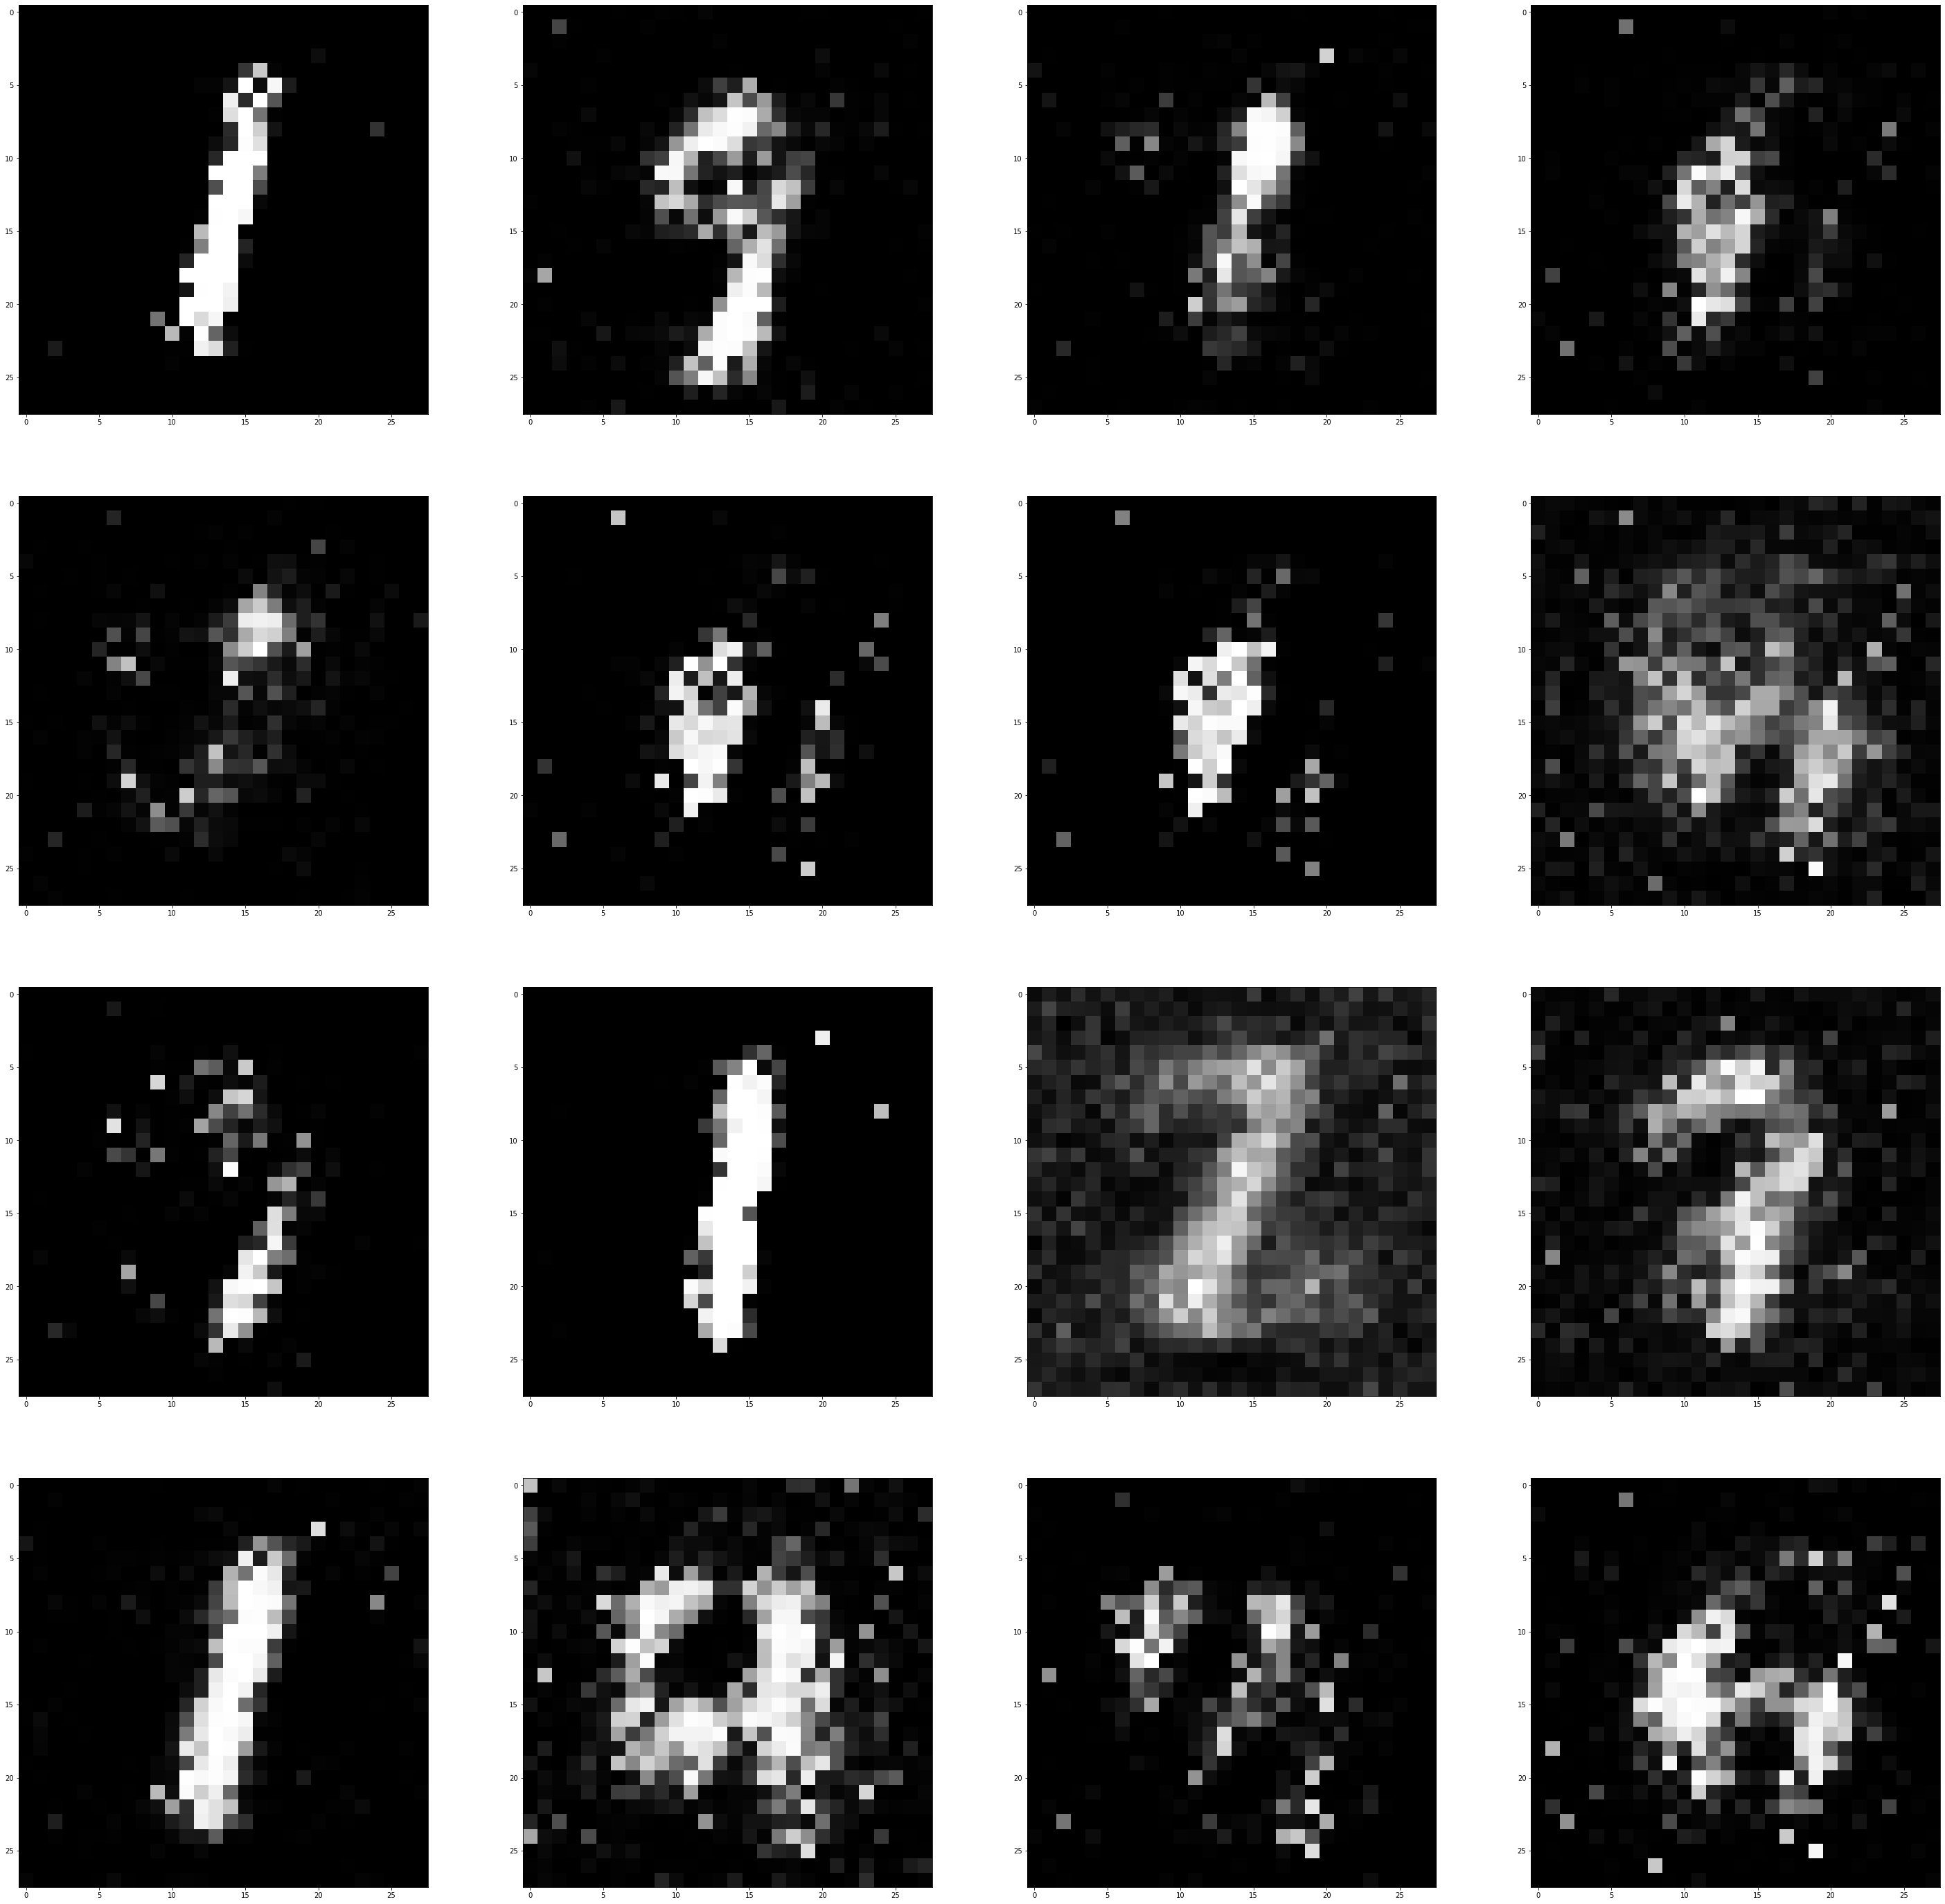

In [ ]:
# Output images
fig = plt.figure(figsize=(50, 50))

for i in range(16):
    sub = fig.add_subplot(4, 4, i + 1)
    sub.imshow(generate_mnist_image(), interpolation='nearest', cmap='gray')

Not bad, we can start to see numbers! If you run this for more epochs, you will notice a much greater improvement in performance.

Here are some things you can try out:
- Run it for more epochs
- Adjust the model architecture for the Generator/Discriminator
- Adjust the hyperparameters of the Generator/Discriminator
- Try your own datasets

After doing any of things, what do you notice about how the output changes? Why do you think your adjustment accounted for this case?



---



---

## 4. BONUS: Modern GANs

So we built our own GAN from scratch with Pytorch, but as you may have noticed, the process is incredibly slow and we're only running the most basic version of GAN. Recent advancements have allowed greater performance for this type of model.

One of these advancements is NVIDIA's StyleGAN, which has demonstrated incredible capability of generating realistic images like faces.

Let's look at pretrained version of StyleGAN2, specifically trained on a dataset of tens of thousands of faces known as FFHQ. This was trained for days, even with 8 GPUs!

In [ ]:
# Clone a simplified version of Tensorflow StyleGAN2

# Credit: rosasalberto, rileypsmith
!git clone https://github.com/rosasalberto/StyleGAN2-TensorFlow-2.x.git

In [ ]:
%cd '/StyleGAN2-TensorFlow-2.x'

In [ ]:
# Imports
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from utils.utils_stylegan2 import convert_images_to_uint8

from stylegan2_generator import StyleGan2Generator

In [ ]:
# Generator (turn gpu=False if using cpu)

'''
To download the weights for the StyleGAN2 trained on FFHQ:
1. You must download the following folder: https://drive.google.com/file/d/1kyuIUeHeLAS5i7dD16byD1NXj0aHUA85/view?usp=sharing
2. Navigate to StyleGAN2-Tensorflow-2.x in your temporary drive on the left hand side of Colab
3. Put the downloaded folder in the 'weights' folder
'''

generator = StyleGan2Generator(weights='ffhq', impl='ref', gpu=True)

Loaded ffhq generator weights!


In [ ]:
# Generate image
def generate(z):
    # running mapping network
    dlatents = generator.mapping_network(z)
    # running synthesis network
    out = generator.synthesis_network(dlatents)
    #converting image/s to uint8
    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=False)
    return img

In [ ]:
# Latent vector (random starting point)
start_zp = np.random.normal(size=(1, 512))
zp = tf.Variable(start_zp, trainable=True, dtype=tf.float32)

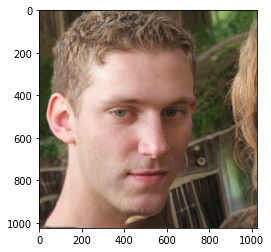

In [ ]:
# Awesome!
plt.imshow(generate(zp).numpy()[0]/255)



---



---



---



## 5. Future and Applications

Clearly, GANs are a powerful tool. We've seen how effective the adversarial training process can be in generative machine learning.

There are many more iterations of GAN. If you did the bonus exercise, we worked with StyleGAN2, but there's also a StyleGAN3. There are also variations like Progressive GANs and Deep Convolutional GANs, which are improvements over classic GAN.

Here are some applications of GAN today:

1. Data augmentation
2. Medical Imaging Quality Enhancement
3. Augmented Reality Enhancements
4. Speech enhancement

Read more here: https://medium.com/sciforce/whats-next-for-gans-latest-techniques-and-applications-3be06a7e5ab9#:~:text=Generative%20Adversarial%20Networks%20(GANs)%20are,learns%20to%20mimic%20camera%20motion.

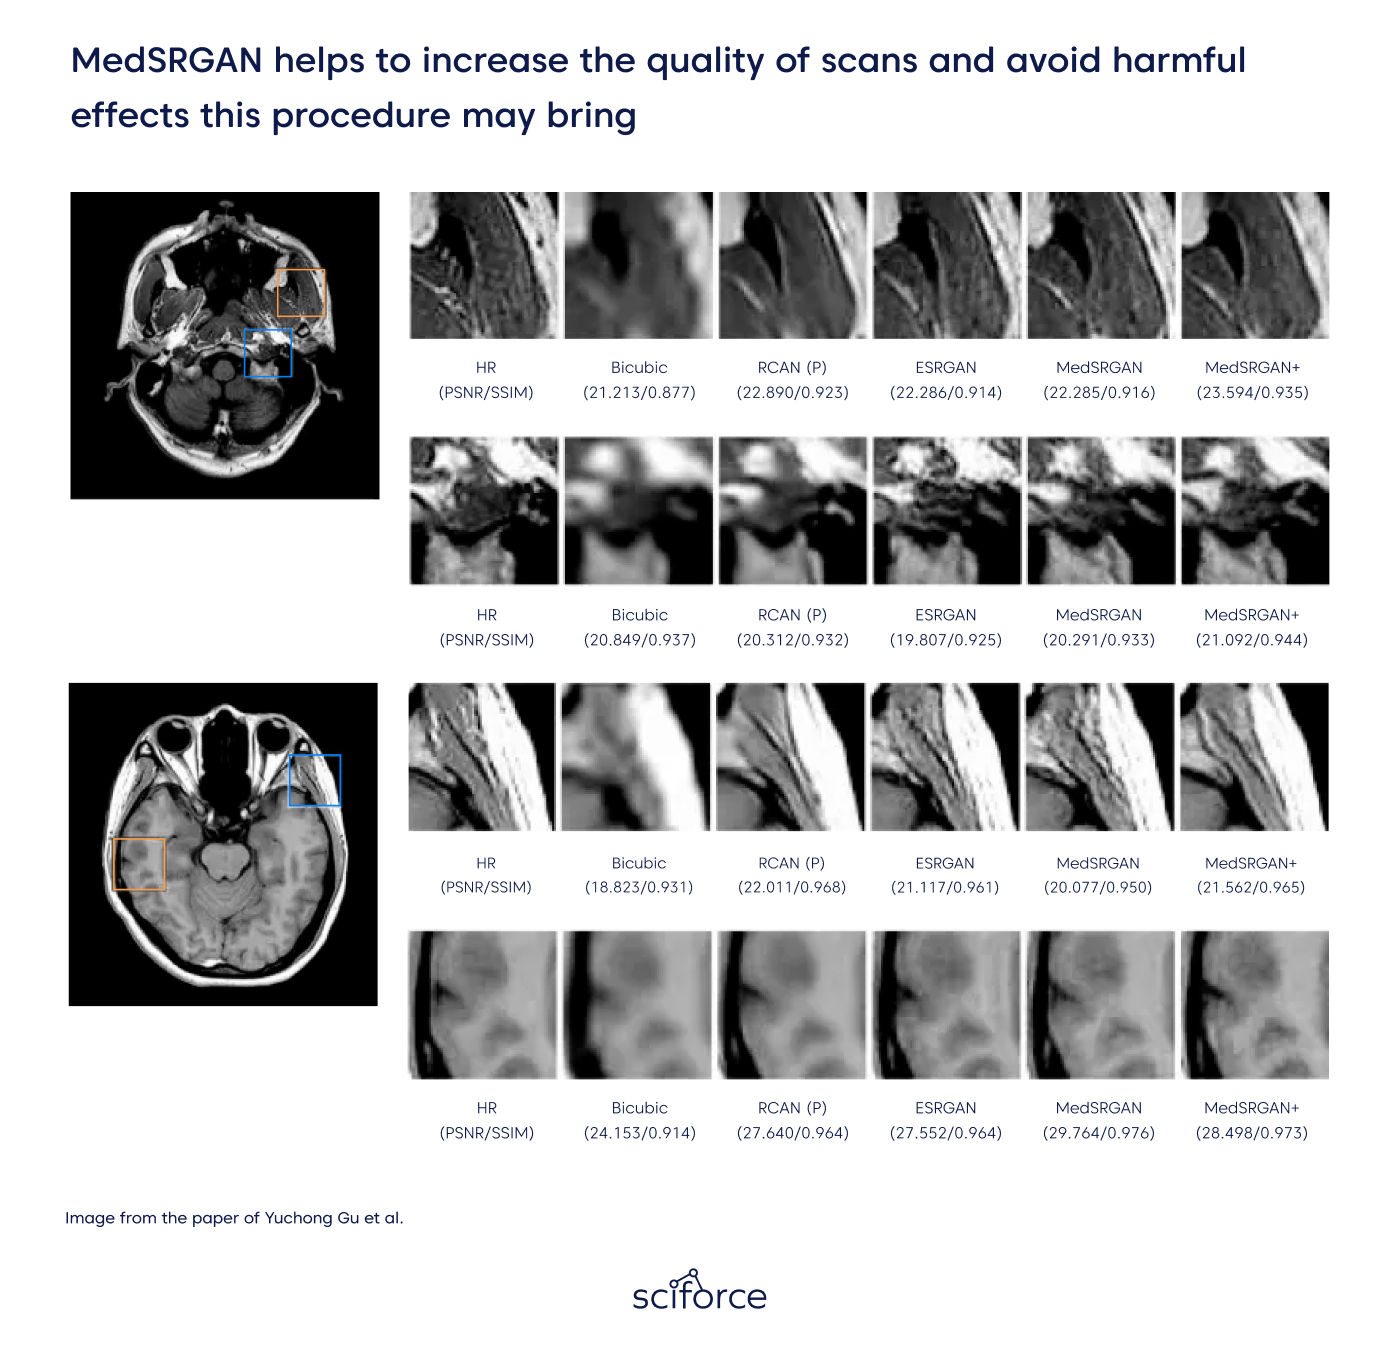

Resources and References:
- Papers:
 - https://arxiv.org/abs/1406.2661
 - https://arxiv.org/abs/1912.04958

- References Used for this Tutorial/More tutorials
 - https://www.kaggle.com/code/kmldas/mnist-generative-adverserial-networks-in-pytorch/notebook
 - https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/
 - https://www.run.ai/guides/deep-learning-for-computer-vision/pytorch-gan
 - https://debuggercafe.com/vanilla-gan-pytorch/
 - https://deeplearning.neuromatch.io/tutorials/W2D4_GenerativeModels/student/W2D4_Tutorial3.html